# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it. I look at used cars below.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/charlottesville-va/apa?lat=38.0345&lon=-78.4865&search_distance=102#search=1~gallery~0~0'
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tages, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

## 2. Get your search results of interest and extract data from them, using code similar to what's below.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [55]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

For each listing, we'll use the `.find` method to search within the listing record for specific information. To get the information we want, we can then use `.get_text()`.

In the code below, two more things happen.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [58]:
import re
import numpy as np

criteria = ['1-br', '1 bedroom', '1 bdr', '1br', 'studio']

data = []
for k in range(len(listings)):
    title = listings[k].find('div', class_='title').get_text().lower()
    price_text = listings[k].find('div', class_='price').get_text()

    price = re.sub(r'[^\d]', '', price_text) 
    if price.isdigit():
        price = int(price)
    else:
        price = np.nan  

    link = listings[k].find(href=True)['href']

    living_type = 'missing'
    if not re.search(r'2br|2 bedroom|2 bdr|3br|3 bedroom|3 bdr', title):
        for criterion in criteria:
            if re.search(criterion.replace(' ', r'[- ]*'), title):
                living_type = criterion
                break

    if 1000 <= price <= 2200 and living_type != 'missing':
        data.append({'title': title, 'price': price, 'link': link, 'living type': living_type})

print(data)


[{'title': '1 bedroom, efficient appliances, ceiling fan', 'price': 1355, 'link': 'https://washingtondc.craigslist.org/mld/apa/d/temple-hills-bedroom-efficient/7787408486.html', 'living type': '1 bedroom'}, {'title': 'cable ready, fitness center, studio 1/ba', 'price': 1850, 'link': 'https://washingtondc.craigslist.org/doc/apa/d/washington-cable-ready-fitness-center/7781372107.html', 'living type': 'studio'}, {'title': 'fabulous studio  376 sq feet in a prime location!', 'price': 1880, 'link': 'https://washingtondc.craigslist.org/doc/apa/d/washington-fabulous-studio-376-sq-feet/7787558960.html', 'living type': 'studio'}, {'title': 'perfect studio just for you! rent today at 1500 arlington', 'price': 1960, 'link': 'https://washingtondc.craigslist.org/doc/apa/d/arlington-perfect-studio-just-for-you/7781715487.html', 'living type': 'studio'}, {'title': 'available end of november, furnished, independent 1 bedroom unit in si', 'price': 1700, 'link': 'https://washingtondc.craigslist.org/mld/

## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [59]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = pd.to_numeric(df['price'],errors='coerce')
print(df.shape)
df.to_csv('craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(40, 4)


,title,price,link,living type
0,"1 bedroom, efficient appliances, ceiling fan",1355,https://washingtondc.craigslist.org/mld/apa/d/...,1 bedroom
1,"cable ready, fitness center, studio 1/ba",1850,https://washingtondc.craigslist.org/doc/apa/d/...,studio
2,fabulous studio 376 sq feet in a prime location!,1880,https://washingtondc.craigslist.org/doc/apa/d/...,studio
3,perfect studio just for you! rent today at 150...,1960,https://washingtondc.craigslist.org/doc/apa/d/...,studio
4,"available end of november, furnished, independ...",1700,https://washingtondc.craigslist.org/mld/apa/d/...,1 bedroom


With the data in and wrangled, we can now do EDA:

count      40.000000
mean     1707.500000
std       230.899468
min      1179.000000
25%      1552.750000
50%      1790.500000
75%      1878.500000
max      2149.000000
Name: price, dtype: float64


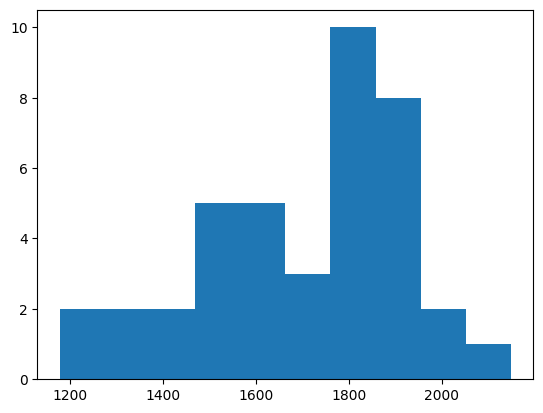

count         40
unique         4
top       studio
freq          24
Name: living type, dtype: object


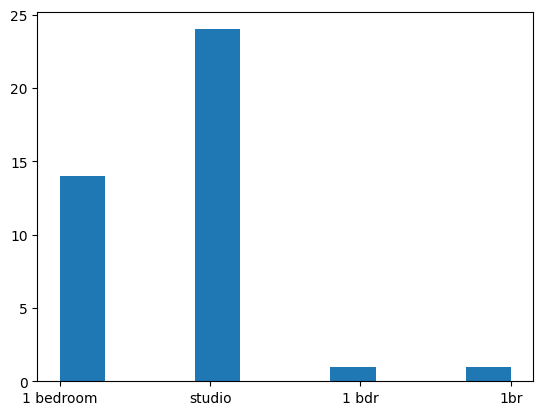

In [60]:
# EDA for price and living type:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['living type'].describe())
df['living type'].hist(grid=False)
plt.show()

In [61]:
# Price by living type:
df.loc[:,['price','living type']].groupby('price').describe()

living type                       
            count unique        top freq
price                                   
1179            2      1     studio    2
1300            1      1     studio    1
1355            1      1  1 bedroom    1
1400            1      1     studio    1
1419            1      1  1 bedroom    1
1499            1      1        1br    1
1500            1      1  1 bedroom    1
1509            1      1  1 bedroom    1
1525            1      1     studio    1
1562            1      1  1 bedroom    1
1585            1      1  1 bedroom    1
1610            1      1     studio    1
1635            1      1  1 bedroom    1
1637            1      1     studio    1
1660            1      1  1 bedroom    1
1675            2      1  1 bedroom    2
1700            1      1  1 bedroom    1
1771            1      1  1 bedroom    1
1810            1      1     studio    1
1829            1      1     studio    1
1844            6      1     studio    6
1850            1      1     studio    1
1878            1      1  1 bedroom    1
1880            1      1     studio    1
1895            1      1     studio    1
1899            1      1      1 bdr    1
1910            1      1     studio    1
1920            2      1     studio    2
1950            1      1     studio    1
1960            1      1     studio    1
2011            1      1     studio    1
2149            1      1  1 bedroom    1

In [62]:
# living type by price:
df.loc[:,['living type','price']].groupby('living type').describe()

price                                                             \
            count         mean         std     min      25%     50%      75%   
living type                                                                    
1 bdr         1.0  1899.000000         NaN  1899.0  1899.00  1899.0  1899.00   
1 bedroom    14.0  1648.071429  198.917248  1355.0  1522.25  1647.5  1693.75   
1br           1.0  1499.000000         NaN  1499.0  1499.00  1499.0  1499.00   
studio       24.0  1742.875000  247.180679  1179.0  1630.25  1844.0  1898.75   

                     
                max  
living type          
1 bdr        1899.0  
1 bedroom    2149.0  
1br          1499.0  
studio       2011.0

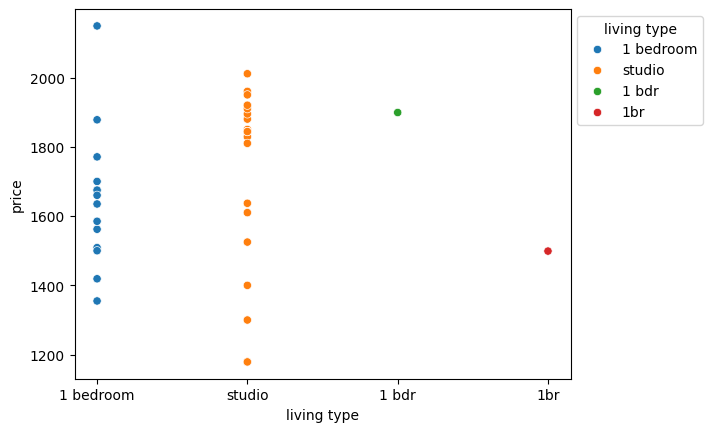

In [63]:
ax = sns.scatterplot(data=df, x='living type', y='price',hue='living type')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

> Using all of this data and all of these visualizations, we can come to the simple conclusion that housing is expensive. On a deeper note, we can see that '1 bedroom' is used much more frequently than other alternatives such as '1 bdr' or '1br' but interesting enough, '1-br' is not used at all. Studios were the most common and had the largest standard deviation, though only 1 bedroom living situations had enough data to calculate a standard deviation. The histogram chart for rent prices has a grouping around the $1800 - $1900 mark which is an unfortunate place to have the skew come to a maximum. There is also a surge in the $1400 - $1500 area which, despite being not as significant as the $1800 - $1900 surge, nice to see at the friendlier price range. 